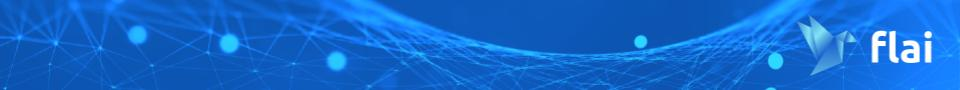

# **Modelo para Previsão de Fraudes em Cartão de Crédito**
 

  
https://www.kaggle.com/mlg-ulb/creditcardfraud


---
## **Objetivo**


Entender e resolver o problema de desbalanceamento na variável resposta em problemas de classificação binária.

---
## **Importação dos Dados**

In [61]:
# importação dos dados direto do site da UCI
import pandas as pd

caminho = '/content/creditcard.csv' 

dados = pd.read_csv(caminho)  
dados.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [62]:
dados['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [64]:
dados.shape

(284807, 31)

In [65]:
dados['Class'].value_counts()/dados.shape[0]

0    0.998273
1    0.001727
Name: Class, dtype: float64

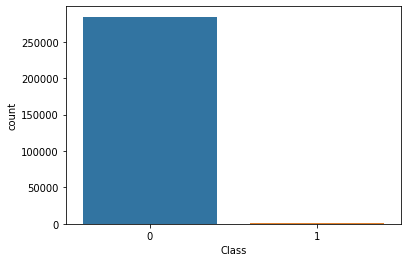

In [68]:
import seaborn as sns

sns.countplot(x = dados['Class']);

---
## **Por qual razão as técnicas usuais falham em conjuntos desbalanceados?**

In [69]:
def AmostraEstratificada(dados, tamanho): 
    n1 = round(tamanho*dados['Class'].mean())
    n0 = tamanho - n1

    zeros = dados[dados['Class'] == 0]
    uns = dados[dados['Class'] == 1] 

    am0 = zeros.sample(n0)
    am1 = uns.sample(n1)

    amostra = pd.concat([am0, am1])
    resto = dados.drop(amostra.index)

    return amostra, resto

In [ ]:
validacao, treinamento = AmostraEstratificada(dados, dados.shape[0] - 200000)

In [70]:
print(treinamento.shape)
print(treinamento['Class'].mean())

print(validacao.shape)
print(validacao['Class'].mean())

(200000, 31)
0.001725
(84807, 31)
0.0017333474831087057


---

In [ ]:
!pip install pycaret 

In [72]:
?setup

In [71]:
from pycaret.classification import setup, models, create_model, compare_models, tune_model, predict_model, plot_model, predict_model, evaluate_model, finalize_model, save_model

In [ ]:
# Configuração da Modelagem automática feita pelo PyCaret
# Envolve os procedimentos de validação quanto de pré-processamento

modelagem = setup(data = treinamento,
                  target = 'Class',
                  test_data = validacao,
                  normalize = True) 

In [ ]:
# Modelos considerados nessa analise

modelos = ['et','rf','lightgbm', 'dt', 'lr', 'svm']

In [ ]:
# Comparação dos modelos selecionados, ordenados por F1-Score

modelo = compare_models(include = modelos, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9994,0.9407,0.7418,0.9142,0.8046,0.8043,0.8158,16.833
lr,Logistic Regression,0.9992,0.9408,0.6229,0.9112,0.7196,0.7192,0.7423,1.565
svm,SVM - Linear Kernel,0.9991,0.0000,0.5685,0.9110,0.6760,0.6756,0.7063,0.505
lightgbm,Light Gradient Boosting Machine,0.9963,0.7013,0.5255,0.2633,0.3397,0.3381,0.3639,3.617
rf,Random Forest Classifier,0.9030,0.9384,0.7624,0.8344,0.7374,0.7368,0.7432,136.129
dt,Decision Tree Classifier,0.8976,0.8139,0.7299,0.5484,0.5427,0.5415,0.5583,12.614


In [ ]:
# Predição do melhor modelo nos dados de validação

pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9996,0.9367,0.7823,0.9583,0.8614,0.8612,0.8657


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Label,Score
0,-1.767498,0.602109,0.062153,0.000741,1.186692,1.324682,3.287947,-0.993858,0.874097,1.046359,0.224366,0.307879,-2.647093,1.710321,1.321478,-0.449999,1.239459,-0.403416,0.941953,-1.101539,-0.074540,-0.128010,-0.105292,-0.119481,1.570224,1.013724,0.173000,0.033655,0.070621,-0.325086,0,0,1.00
1,-0.352350,0.389089,-0.841316,-0.508010,-0.496866,0.788281,2.890195,-0.741416,0.790052,0.676691,-0.299749,-0.332314,0.154463,0.148961,-0.158352,0.996805,0.831011,-0.883467,0.454823,0.283118,0.793701,0.244601,-0.110865,-0.474780,1.830304,0.527695,2.273524,-0.208121,0.173565,0.753314,0,0,1.00
2,-0.917189,0.418140,-1.191037,0.663031,-0.233912,-1.179111,1.086665,-1.199540,0.441495,0.516770,0.272320,-0.085535,0.064460,-0.573331,-1.073629,-1.820771,0.869557,0.793278,-1.113085,1.436953,0.626850,0.398148,0.874375,-0.597776,-1.230679,0.720813,-0.023203,0.119219,0.143392,0.628704,0,0,1.00
3,0.466486,0.915892,-1.065738,-1.638351,-1.244011,1.012179,2.648211,-0.859023,0.666970,-0.272514,0.628327,0.008025,-0.403597,0.073067,-0.071320,0.437812,1.020290,0.191893,-1.874834,0.532437,0.571212,0.384156,0.444585,0.077246,1.209545,-0.306821,-0.420330,-0.067013,-0.078833,0.483866,0,0,1.00
4,-0.238814,0.511692,-0.103388,-0.067115,0.818913,-0.134609,-0.274449,0.222966,-0.028328,0.043266,0.083732,0.565433,0.286195,-1.339601,0.725497,-0.550760,-0.062404,-0.467853,0.406811,0.381898,0.015182,0.070832,-0.050286,-0.458173,0.009579,1.492615,-0.584391,-0.056742,0.056362,0.118007,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84802,-1.390406,-14.928726,9.785895,-19.865122,4.578652,-15.503534,-3.689492,-16.174379,15.928038,-3.296229,-7.241606,3.988413,-5.687072,1.296726,-5.321148,-0.140650,-5.998995,-13.356657,-5.583158,0.801723,2.240048,2.442522,-2.994775,-2.166555,0.286759,4.038322,-0.434334,3.193210,1.165915,0.048096,1,1,0.97
84803,-0.768832,-0.228192,0.769610,0.797082,0.559367,0.305466,-0.639024,0.750164,-0.194770,-0.260825,-0.798436,0.603781,-0.660838,-0.952611,-1.713502,1.376809,0.079120,1.571744,0.448012,-1.347195,-0.087145,0.162780,0.707676,-0.419879,0.730732,0.056796,-0.694047,-0.470935,-0.384049,-0.335848,1,0,1.00
84804,-1.832929,0.357909,1.469283,-3.465549,3.122535,-1.586043,-2.007670,-3.169224,0.758156,-0.151954,-4.609143,4.586118,-8.204129,0.640006,-7.084271,1.413560,-4.359961,-4.446549,-1.252899,1.912946,0.552317,0.745366,-0.012746,1.144462,0.780133,-3.760560,0.663910,1.499844,0.405954,-0.352395,1,1,0.96
84805,1.025661,-1.027099,2.226568,-3.617305,5.112539,-1.189482,-0.750655,-3.513898,1.886138,-3.327048,-4.049391,4.132533,-5.763741,-0.879634,-9.315437,-0.616627,-3.753666,-5.174985,-0.880107,1.980717,0.619756,0.964866,-0.087179,0.265855,-0.743280,0.045636,1.114953,1.213650,-0.130826,-0.352395,1,1,0.99


---
## **Undersampling**


In [73]:
def UnderSampling(dados, under = 1):
    classe0 = dados[dados['Class'] == 0]
    classe1 = dados[dados['Class'] == 1]  
    
    amostra0 = classe0.sample(under * classe1.shape[0])
    under = pd.concat([amostra0, classe1])

    return under

In [74]:
under1 = UnderSampling(dados, 1) 
under2 = UnderSampling(dados, 2) 
under5 = UnderSampling(dados, 5)
under10 = UnderSampling(dados, 10)
under25 = UnderSampling(dados, 25)  
under40 = UnderSampling(dados, 40)  

print(under1.shape)
print(under2.shape)
print(under5.shape)
print(under10.shape)
print(under25.shape) 
print(under40.shape) 

(984, 31)
(1476, 31)
(2952, 31)
(5412, 31)
(12792, 31)
(20172, 31)


---

In [75]:
modelagem = setup(data = under1, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9360,0.9758,0.9045,0.9660,0.9321,0.8720,0.8767,0.618
lightgbm,Light Gradient Boosting Machine,0.9319,0.9753,0.8964,0.9651,0.9277,0.8638,0.8684,0.380
lr,Logistic Regression,0.9308,0.9754,0.8944,0.9650,0.9267,0.8617,0.8662,0.034
et,Extra Trees Classifier,0.9278,0.9773,0.8781,0.9755,0.9225,0.8556,0.8621,0.748
svm,SVM - Linear Kernel,0.9197,0.0000,0.9146,0.9259,0.9183,0.8394,0.8425,0.018
dt,Decision Tree Classifier,0.8670,0.8668,0.8432,0.8759,0.8522,0.7336,0.7391,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.98,0.9996,1.0,0.0797,0.1476,0.1448,0.2794


---

In [ ]:
modelagem = setup(data = under2, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9566,0.9733,0.8863,0.9821,0.9299,0.8989,0.9030,0.771
lr,Logistic Regression,0.9560,0.9768,0.8944,0.9720,0.9297,0.8979,0.9013,0.034
lightgbm,Light Gradient Boosting Machine,0.9546,0.9754,0.8884,0.9745,0.9272,0.8945,0.8987,0.369
et,Extra Trees Classifier,0.9546,0.9788,0.8782,0.9844,0.9263,0.8939,0.8986,0.515
svm,SVM - Linear Kernel,0.9431,0.0000,0.8802,0.9480,0.9102,0.8688,0.8727,0.020
dt,Decision Tree Classifier,0.9140,0.9051,0.8782,0.8676,0.8712,0.8067,0.8085,0.047


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9934,0.9997,1.0,0.207,0.3431,0.3412,0.4535


---

In [ ]:
modelagem = setup(data = under5, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9742,0.9763,0.8533,0.9905,0.9147,0.8997,0.9046,0.575
rf,Random Forest Classifier,0.9732,0.9732,0.8554,0.9819,0.9119,0.8963,0.9008,1.281
lightgbm,Light Gradient Boosting Machine,0.9722,0.9747,0.8554,0.9754,0.9089,0.8927,0.8971,0.431
lr,Logistic Regression,0.9688,0.9639,0.8415,0.9667,0.8978,0.8796,0.8839,0.042
svm,SVM - Linear Kernel,0.9661,0.0000,0.8677,0.9268,0.8945,0.8744,0.8762,0.024
dt,Decision Tree Classifier,0.9519,0.9018,0.8268,0.8729,0.8427,0.8150,0.8192,0.089


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9988,0.9999,1.0,0.5951,0.7462,0.7456,0.771


---

In [ ]:
modelagem = setup(data = under10, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9854,0.9747,0.8473,0.9905,0.9111,0.9033,0.9078,0.690
rf,Random Forest Classifier,0.9850,0.9732,0.8493,0.9834,0.9092,0.9011,0.9053,2.207
lightgbm,Light Gradient Boosting Machine,0.9845,0.9776,0.8493,0.9776,0.9065,0.8981,0.9022,0.506
lr,Logistic Regression,0.9832,0.9710,0.8373,0.9752,0.8986,0.8895,0.8940,0.058
svm,SVM - Linear Kernel,0.9823,0.0000,0.8514,0.9476,0.8951,0.8855,0.8880,0.033
dt,Decision Tree Classifier,0.9760,0.9245,0.8615,0.8752,0.8659,0.8527,0.8542,0.183


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9991,0.9999,1.0,0.6652,0.7989,0.7985,0.8152


---

In [ ]:
modelagem = setup(data = under25, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9928,0.9673,0.8272,0.9827,0.8962,0.8925,0.8972,5.572
lightgbm,Light Gradient Boosting Machine,0.9926,0.9738,0.8251,0.9780,0.8933,0.8895,0.8939,0.701
et,Extra Trees Classifier,0.9923,0.9681,0.8131,0.9826,0.8867,0.8828,0.8887,1.044
lr,Logistic Regression,0.9912,0.9685,0.8028,0.9633,0.8726,0.8681,0.8737,0.102
svm,SVM - Linear Kernel,0.9910,0.0000,0.7949,0.9657,0.8682,0.8637,0.8700,0.078
dt,Decision Tree Classifier,0.9823,0.8506,0.7079,0.7858,0.7378,0.7291,0.7335,0.478


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9994,0.9999,0.9932,0.7337,0.8439,0.8436,0.8534


---

In [ ]:
modelagem = setup(data = under40, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9958,0.9695,0.8392,0.9892,0.9052,0.9031,0.9078,9.816
et,Extra Trees Classifier,0.9954,0.9739,0.8190,0.9913,0.8940,0.8917,0.8974,1.432
lightgbm,Light Gradient Boosting Machine,0.9947,0.9723,0.8010,0.9819,0.8790,0.8763,0.8828,0.845
lr,Logistic Regression,0.9945,0.9605,0.8009,0.9691,0.8731,0.8703,0.8765,0.144
svm,SVM - Linear Kernel,0.9938,0.0000,0.7908,0.9435,0.8570,0.8539,0.8591,0.169
dt,Decision Tree Classifier,0.9905,0.8860,0.7762,0.8226,0.7754,0.7711,0.7814,0.861


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9995,0.9999,1.0,0.7617,0.8647,0.8644,0.8725


---
## **Oversampling**


In [76]:
def UnderOverSampling(dados, under = 1, over = 1):
    classe0 = dados[dados['Class'] == 0]
    classe1 = dados[dados['Class'] == 1]  

    amostra0 = classe0.sample(under * classe1.shape[0])
    amostra1 = pd.concat([classe1] * over, ignore_index=True)
    tudo = pd.concat([amostra0, amostra1])

    return tudo

In [77]:
underover1 = UnderOverSampling(dados, under = 20, over = 4)
underover2 = UnderOverSampling(dados, under = 20, over = 8)
underover3 = UnderOverSampling(dados, under = 20, over = 12)
underover4 = UnderOverSampling(dados, under = 20, over = 16)
underover5 = UnderOverSampling(dados, under = 20, over = 20)

print(underover1.shape)
print(underover2.shape)
print(underover3.shape)
print(underover4.shape)
print(underover5.shape)  

(11808, 31)
(13776, 31)
(15744, 31)
(17712, 31)
(19680, 31)


---

In [ ]:
modelagem = setup(data = underover1, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9995,1.0000,1.0000,0.9970,0.9985,0.9982,0.9982,1.307
rf,Random Forest Classifier,0.9992,0.9999,1.0000,0.9955,0.9977,0.9973,0.9973,4.539
lightgbm,Light Gradient Boosting Machine,0.9991,0.9998,1.0000,0.9945,0.9972,0.9967,0.9967,0.718
dt,Decision Tree Classifier,0.9912,0.9947,1.0000,0.9500,0.9743,0.9690,0.9695,0.375
lr,Logistic Regression,0.9745,0.9840,0.8724,0.9719,0.9193,0.9042,0.9062,0.110
svm,SVM - Linear Kernel,0.9724,0.0000,0.8659,0.9653,0.9126,0.8963,0.8983,0.062


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9995,1.0,1.0,0.7778,0.875,0.8748,0.8817


---

In [ ]:
modelagem = setup(data = underover2, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9995,0.9999,1.0000,0.9982,0.9991,0.9988,0.9988,1.018
rf,Random Forest Classifier,0.9994,0.9999,1.0000,0.9980,0.9990,0.9986,0.9986,4.236
lightgbm,Light Gradient Boosting Machine,0.9991,0.9999,1.0000,0.9967,0.9984,0.9977,0.9977,0.713
dt,Decision Tree Classifier,0.9939,0.9957,1.0000,0.9792,0.9895,0.9852,0.9853,0.326
lr,Logistic Regression,0.9636,0.9857,0.8966,0.9741,0.9337,0.9087,0.9102,0.132
svm,SVM - Linear Kernel,0.9604,0.0000,0.8905,0.9686,0.9278,0.9006,0.9022,0.083


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9995,1.0,1.0,0.7696,0.8698,0.8696,0.8771


---

In [ ]:
modelagem = setup(data = underover3, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.083
rf,Random Forest Classifier,0.9999,1.0000,1.0000,0.9997,0.9998,0.9997,0.9997,4.097
lightgbm,Light Gradient Boosting Machine,0.9995,1.0000,1.0000,0.9987,0.9993,0.9989,0.9989,0.738
dt,Decision Tree Classifier,0.9947,0.9958,1.0000,0.9861,0.9930,0.9888,0.9889,0.313
lr,Logistic Regression,0.9601,0.9864,0.9141,0.9781,0.9450,0.9138,0.9151,0.197
svm,SVM - Linear Kernel,0.9505,0.0000,0.9070,0.9598,0.9323,0.8933,0.8947,0.080


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9994,0.9999,1.0,0.7462,0.8547,0.8544,0.8636


---

In [ ]:
modelagem = setup(data = underover4, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9995,1.0000,1.0000,0.9989,0.9994,0.9990,0.9990,1.145
rf,Random Forest Classifier,0.9993,0.9999,1.0000,0.9985,0.9992,0.9986,0.9986,4.251
lightgbm,Light Gradient Boosting Machine,0.9993,0.9999,1.0000,0.9985,0.9992,0.9986,0.9986,0.784
dt,Decision Tree Classifier,0.9951,0.9956,1.0000,0.9891,0.9945,0.9901,0.9901,0.287
lr,Logistic Regression,0.9547,0.9867,0.9198,0.9770,0.9475,0.9078,0.9091,0.201
svm,SVM - Linear Kernel,0.9527,0.0000,0.9190,0.9733,0.9453,0.9038,0.9050,0.112


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9994,1.0,1.0,0.75,0.8571,0.8569,0.8658


---

In [ ]:
modelagem = setup(data = underover5, target = 'Class', test_data = validacao, normalize = True) 
modelo = compare_models(include = modelos, sort = 'F1')
pred = predict_model(modelo)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9996,0.9999,1.0000,0.9992,0.9996,0.9992,0.9992,1.206
rf,Random Forest Classifier,0.9995,1.0000,1.0000,0.9990,0.9995,0.9990,0.9990,4.186
lightgbm,Light Gradient Boosting Machine,0.9991,0.9999,1.0000,0.9983,0.9991,0.9983,0.9983,0.812
dt,Decision Tree Classifier,0.9955,0.9955,1.0000,0.9911,0.9956,0.9911,0.9911,0.292
svm,SVM - Linear Kernel,0.9476,0.0000,0.9232,0.9707,0.9463,0.8952,0.8963,0.118
lr,Logistic Regression,0.9477,0.9863,0.9183,0.9758,0.9461,0.8954,0.8970,0.265


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9996,1.0,1.0,0.7989,0.8882,0.888,0.8936


---
## **Considerações Finais**

- Melhor setup até agora:
 - Estratégia: Under de 20x e Over de 20x
 - Modelo: ExtraTrees.

- Comparação mais robusta entre cenários de over e under sampling
 
- Fazer um pré-processamento mais atencioso (considerar tratamento de outliers, normalizações, categorizações etc)

- Busca mais ampla no rol de modelos - fazer tunagem de hiperparâmetros (requer muito esforço computacional)

- Análise do problema de acordo com alguma métrica conectada ao négocio (análise FP vs FN, matriz de custo etc)

- Considerar técnicas mais robustas para esse propósito: **Near Miss** para undersampling e **SMOTE** (Synthetic Minority Oversampling Technique) para oversampling. 
 - Biblioteca imblearn/pycaret